# Functional Encryption - Classification and information leakage

Our start point is the work on encrypted classification using Function Encryption of the paper [Reading in the Dark: Classifying Encrypted Digits with Functional Encryption](https://eprint.iacr.org/2018/206), and the associated [GitHub repository](https://github.com/edufoursans/reading-in-the-dark).

More specifically, the paper provides a new Functional Encryption scheme for quadratic multi-variate polynomials, which can under some hypothesis be seen as a single hidden layer neural network with a quadratic activation.
In the paper, the output corresponds to element per class, and it is made in clear. We analyse how this output can disclose information about the initial input or about charasteristics of this input.

To this aim, we have just built a dataset which is very similar to MNIST, used in the original paper but which is composed of 26 letter characters of 5 differents fonts. Our goal is two-fold:
 - Evaluate how the output in clear can be leverage with a public NN to make better prediction than a simple `argmax` function in the character recognition task.
 - Analyse to what extent the output in clear of the model trained for character recognition can reveal information about the font used, using an "adversarial" network.
 
Let's run a first evaluation of the model performance!

# 1 Quadratic model evaluation

We will first evaluate performances of the quadratic model alone, so for a neural network with a single hidden layer and a square activation function.

Let's load the dataset we just built

In [1]:
import pickle

train_data, train_target_char, train_target_family = [], [], []

# The training set
for i in range(6): 
    with open(f'dataset/character_dataset_train{i}.pkl', 'rb') as input_file:
        training_set = pickle.load(input_file)
        train_data_i, train_target_char_i, train_target_family_i = training_set
        train_data += train_data_i
        train_target_char += train_target_char_i
        train_target_family += train_target_family_i

# The testing set
with open(f'dataset/character_dataset_test.pkl', 'rb') as input_file:
    testing_set = pickle.load(input_file)
    test_data, test_target_char, test_target_family = testing_set
    
print('Training set', len(train_data), 'items')
print('Testing set ', len(test_data), 'items')

Training set 60000 items
Testing set  10000 items


In [2]:
from __future__ import print_function
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as utils

from torchvision import datasets, transforms

### Our quadratic model
Say hello to our model!

In [3]:
class QuadNet(nn.Module):
    def __init__(self, output_size):
        super(QuadNet, self).__init__()
        self.proj1 = nn.Linear(784, 50)
        self.diag1 = nn.Linear(50, output_size)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        return F.log_softmax(x, dim=1)

### Train and test functions

We now load a classic train and test function. Just notice that we add some manual regularisation as an optional parameter.

In [4]:
def train(args, model, train_loader, optimizer, epoch, reg_l2=None):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        
        # optional regularisation
        if reg_l2 is not None:
            regularization = reg_l2 * (
                model.proj1.bias.norm() ** 2 +
                model.proj1.weight.norm() ** 2 +
                model.diag1.bias.norm() ** 2 +
                model.diag1.weight.norm() ** 2
            )
            loss = loss + regularization

        loss.backward()
        optimizer.step()
        
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item()))


def test(args, model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))
    
    return accuracy

### Last, the main loop

In [5]:
class Parser:
    """Parameters for the training"""
    def __init__(self):
        self.epochs = 20
        self.lr = 0.01
        self.momentum = 0.5
        self.test_batch_size = 1000
        self.batch_size = 64
        self.log_interval = 300
        
def build_tensor_dataset(data, target):
    """Utility function to cast our data into a normalized torch TensorDataset"""
    normed_data = [(d - d.mean()) / d.std() for d in data]
    normed_data = torch.stack([torch.Tensor(d).reshape(1, 28, 28) for d in normed_data])
    target = torch.LongTensor([i[0] for i in target])
    tensor_dataset = utils.TensorDataset(normed_data, target)
    return tensor_dataset
    
def main(task='char', reg_l2=None):
    """
    You can choose to learn on:
    task=(char|family)
    With:
    regularisation_l2=(True|False)
    """
    args = Parser()
    torch.manual_seed(1)
    
    print('Learning on', task, 'with regularisation_l2', reg_l2)
    if task == 'family':
        train_target = train_target_family
        test_target = test_target_family
        output_size = 5
    elif task == 'char':
        train_target = train_target_char
        test_target = test_target_char
        output_size = 26
        
    train_dataset = build_tensor_dataset(train_data, train_target)
    test_dataset = build_tensor_dataset(test_data, test_target)
    
    train_loader = utils.DataLoader(
        train_dataset,
        batch_size=args.batch_size, shuffle=True
    )
    
    test_loader = utils.DataLoader(
        test_dataset,
        batch_size=args.test_batch_size, shuffle=True
    )
    
    model = QuadNet(output_size=output_size)
    
    # optimizer = optim.Adam(model.parameters(), lr=args.lr)
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
    
    test_perfs = []
    for epoch in range(1, args.epochs + 1):
        train(args, model, train_loader, optimizer, epoch, reg_l2)
        if epoch <= args.epochs:
            test_perf = test(args, model, test_loader)
            test_perfs.append(test_perf)

    return test_perfs

### Accuracy results on the character recognition

In [6]:
results = {}
results['QuadNet'] = main()
reg_params = [0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01]
for reg_param in reg_params:
    results[f'QuadNet L2 Reg={reg_param}'] = main(reg_l2=reg_param)

Learning on char with regularisation_l2 None
Train Epoch: 1 [0/60000 (0%)]	Loss: 3.360110
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.779691
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.451562
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.462836

Test set: Average loss: 0.4758, Accuracy: 8623/10000 (86.23%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.267715
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.405997
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.319206
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.364564

Test set: Average loss: 0.3378, Accuracy: 9082/10000 (90.82%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.374597
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.252909
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.351920
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.461423

Test set: Average loss: 0.2691, Accuracy: 9276/10000 (92.76%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.374169
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.096390
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.199888
Train Epoch: 4 [57600/60000 (96%)

Train Epoch: 12 [19200/60000 (32%)]	Loss: 0.156633
Train Epoch: 12 [38400/60000 (64%)]	Loss: 0.294599
Train Epoch: 12 [57600/60000 (96%)]	Loss: 0.097593

Test set: Average loss: 0.2276, Accuracy: 9492/10000 (94.92%)

Train Epoch: 13 [0/60000 (0%)]	Loss: 0.082285
Train Epoch: 13 [19200/60000 (32%)]	Loss: 0.129845
Train Epoch: 13 [38400/60000 (64%)]	Loss: 0.116671
Train Epoch: 13 [57600/60000 (96%)]	Loss: 0.092945

Test set: Average loss: 0.2261, Accuracy: 9483/10000 (94.83%)

Train Epoch: 14 [0/60000 (0%)]	Loss: 0.196899
Train Epoch: 14 [19200/60000 (32%)]	Loss: 0.105284
Train Epoch: 14 [38400/60000 (64%)]	Loss: 0.192402
Train Epoch: 14 [57600/60000 (96%)]	Loss: 0.110411

Test set: Average loss: 0.2125, Accuracy: 9532/10000 (95.32%)

Train Epoch: 15 [0/60000 (0%)]	Loss: 0.142614
Train Epoch: 15 [19200/60000 (32%)]	Loss: 0.108779
Train Epoch: 15 [38400/60000 (64%)]	Loss: 0.127510
Train Epoch: 15 [57600/60000 (96%)]	Loss: 0.150444

Test set: Average loss: 0.2535, Accuracy: 9430/10000 (94.

Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.386837
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.447683
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.564173

Test set: Average loss: 0.2555, Accuracy: 9305/10000 (93.05%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.478963
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.258827
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.345168
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.374925

Test set: Average loss: 0.2462, Accuracy: 9329/10000 (93.29%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.461876
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.448774
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.195653
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.245844

Test set: Average loss: 0.2152, Accuracy: 9427/10000 (94.27%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.208287
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.296119
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.313260
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.306190

Test set: Average loss: 0.2306, Accuracy: 9345/10000 (93.45%)

Train Epo

Train Epoch: 14 [57600/60000 (96%)]	Loss: 0.276668

Test set: Average loss: 0.1550, Accuracy: 9574/10000 (95.74%)

Train Epoch: 15 [0/60000 (0%)]	Loss: 0.258790
Train Epoch: 15 [19200/60000 (32%)]	Loss: 0.259799
Train Epoch: 15 [38400/60000 (64%)]	Loss: 0.278840
Train Epoch: 15 [57600/60000 (96%)]	Loss: 0.254332

Test set: Average loss: 0.1646, Accuracy: 9570/10000 (95.70%)

Train Epoch: 16 [0/60000 (0%)]	Loss: 0.249515
Train Epoch: 16 [19200/60000 (32%)]	Loss: 0.289118
Train Epoch: 16 [38400/60000 (64%)]	Loss: 0.337174
Train Epoch: 16 [57600/60000 (96%)]	Loss: 0.272443

Test set: Average loss: 0.2004, Accuracy: 9406/10000 (94.06%)

Train Epoch: 17 [0/60000 (0%)]	Loss: 0.295599
Train Epoch: 17 [19200/60000 (32%)]	Loss: 0.301484
Train Epoch: 17 [38400/60000 (64%)]	Loss: 0.237555
Train Epoch: 17 [57600/60000 (96%)]	Loss: 0.262022

Test set: Average loss: 0.1787, Accuracy: 9529/10000 (95.29%)

Train Epoch: 18 [0/60000 (0%)]	Loss: 0.291871
Train Epoch: 18 [19200/60000 (32%)]	Loss: 0.271618


Test set: Average loss: 0.2111, Accuracy: 9428/10000 (94.28%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.343599
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.443112
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.430691
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.406354

Test set: Average loss: 0.2200, Accuracy: 9370/10000 (93.70%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.484565
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.488666
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.408374
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.542890

Test set: Average loss: 0.2148, Accuracy: 9419/10000 (94.19%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.401400
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.377929
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.398713
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.516200

Test set: Average loss: 0.2103, Accuracy: 9434/10000 (94.34%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.400394
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.434609
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.402518
Train Epoch: 9

Train Epoch: 17 [19200/60000 (32%)]	Loss: 0.550280
Train Epoch: 17 [38400/60000 (64%)]	Loss: 0.500651
Train Epoch: 17 [57600/60000 (96%)]	Loss: 0.562103

Test set: Average loss: 0.2203, Accuracy: 9380/10000 (93.80%)

Train Epoch: 18 [0/60000 (0%)]	Loss: 0.632888
Train Epoch: 18 [19200/60000 (32%)]	Loss: 0.497003
Train Epoch: 18 [38400/60000 (64%)]	Loss: 0.473452
Train Epoch: 18 [57600/60000 (96%)]	Loss: 0.529225

Test set: Average loss: 0.1866, Accuracy: 9498/10000 (94.98%)

Train Epoch: 19 [0/60000 (0%)]	Loss: 0.510796
Train Epoch: 19 [19200/60000 (32%)]	Loss: 0.632457
Train Epoch: 19 [38400/60000 (64%)]	Loss: 0.519616
Train Epoch: 19 [57600/60000 (96%)]	Loss: 0.579683

Test set: Average loss: 0.2113, Accuracy: 9425/10000 (94.25%)

Train Epoch: 20 [0/60000 (0%)]	Loss: 0.515548
Train Epoch: 20 [19200/60000 (32%)]	Loss: 0.529209
Train Epoch: 20 [38400/60000 (64%)]	Loss: 0.545410
Train Epoch: 20 [57600/60000 (96%)]	Loss: 0.451736

Test set: Average loss: 0.1967, Accuracy: 9451/10000 (94.

Let's display the results nicely!
We use a function which is already written in our module `learn`.

In [7]:
# chnage path to import parent modules
import sys, os
sys.path.insert(1, os.path.realpath(os.path.pardir))
import learn

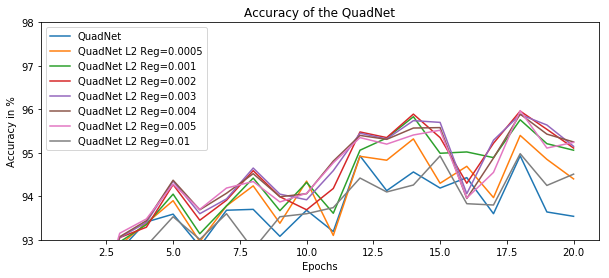

In [8]:
learn.show_results(results, 'Accuracy of the QuadNet', ymin=93, ymax=98)

We observe that a bit of regularisation is helpful and provides a `~1.5%` accuracy boost which is quite significant with these accuracies > 95%. We will keep the regularisation parameter `reg L2=0.003` and assess in the further experiment how this choice can evolve. Our reference accuracy is `95.15%` with regularisation (average on the last 5 epochs), and `93.54%` without.

**Discussion**


Since our dataset is not standard, you may want to know how this model performs compared to usual models. As a reference model, we suggest using the CNN given in the [official Pytorch tutorial on MNIST](https://github.com/pytorch/examples/blob/master/mnist/main.py) as we believe our dataset to be quite similar.

In [9]:
class CNN(nn.Module):
    def __init__(self, output_size):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, output_size)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In order to use it, we will add a parameter to our `main` `train` and `test` functions, which specifies the model type. Except this, nothing changes.

In [10]:
def train(args, model, train_loader, optimizer, epoch, model_type, reg_l2=None):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        if model_type == 'quad' and reg_l2 is not None:
            regularization = reg_l2 * (
                model.proj1.bias.norm() ** 2 +
                model.proj1.weight.norm() ** 2 +
                model.diag1.bias.norm() ** 2 +
                model.diag1.weight.norm() ** 2
            )
            loss = loss + regularization

        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item()))


def test(args, model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    acc = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), acc))
    
    return acc


def main(model_type, task='char', reg_l2=None, epochs=20):
    """
    You can choose to learn on:
    task=(char|family)
    model_type=(quad|cnn)
    """
    args = Parser()
    args.epochs = epochs
    torch.manual_seed(1)
    
    target_types = ['family', 'char']
    print('Learning on', task, 'with', model_type, 'and reg_l2' if reg_l2 else '')
    if task == 'family':
        train_target = train_target_family
        test_target = test_target_family
        output_size = 5
    elif task == 'char':
        train_target = train_target_char
        test_target = test_target_char
        output_size = 26
    
    train_dataset = build_tensor_dataset(train_data, train_target)
    test_dataset = build_tensor_dataset(test_data, test_target)
    
    train_loader = utils.DataLoader(
        train_dataset,
        batch_size=args.batch_size, shuffle=True
    )
    
    test_loader = utils.DataLoader(
        test_dataset,
        batch_size=args.test_batch_size, shuffle=True
    )
    assert model_type in ['quad', 'cnn']
    if model_type == 'quad':
        model = QuadNet(output_size=output_size)
    elif model_type == 'cnn':
        model = CNN(output_size=output_size)

    # optimizer = optim.Adam(model.parameters(), lr=args.lr)
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
    
    test_perfs = []
    for epoch in range(1, args.epochs + 1):
        train(args, model, train_loader, optimizer, epoch, model_type, reg_l2)
        if epoch <= args.epochs:
            test_perf = test(args, model, test_loader)
            test_perfs.append(test_perf)
        
    return test_perfs

In [11]:
results_cnn = {}
results_cnn['QuadNet (without L2 reg)'] = main(model_type='quad')
results_cnn['QuadNet (L2 Reg=0.003)'] = main(model_type='quad', reg_l2=0.003)
results_cnn['CNN'] = main(model_type='cnn')

Learning on char with quad 
Train Epoch: 1 [0/60000 (0%)]	Loss: 3.360110
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.779691
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.451562
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.462836

Test set: Average loss: 0.4758, Accuracy: 8623/10000 (86.23%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.267715
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.405997
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.319206
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.364564

Test set: Average loss: 0.3378, Accuracy: 9082/10000 (90.82%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.374597
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.252909
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.351920
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.461423

Test set: Average loss: 0.2691, Accuracy: 9276/10000 (92.76%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.374169
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.096390
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.199888
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.261964


Train Epoch: 12 [19200/60000 (32%)]	Loss: 0.204813
Train Epoch: 12 [38400/60000 (64%)]	Loss: 0.330915
Train Epoch: 12 [57600/60000 (96%)]	Loss: 0.167477

Test set: Average loss: 0.2033, Accuracy: 9506/10000 (95.06%)

Train Epoch: 13 [0/60000 (0%)]	Loss: 0.128388
Train Epoch: 13 [19200/60000 (32%)]	Loss: 0.168401
Train Epoch: 13 [38400/60000 (64%)]	Loss: 0.135423
Train Epoch: 13 [57600/60000 (96%)]	Loss: 0.141660

Test set: Average loss: 0.1975, Accuracy: 9534/10000 (95.34%)

Train Epoch: 14 [0/60000 (0%)]	Loss: 0.214676
Train Epoch: 14 [19200/60000 (32%)]	Loss: 0.134051
Train Epoch: 14 [38400/60000 (64%)]	Loss: 0.241044
Train Epoch: 14 [57600/60000 (96%)]	Loss: 0.157361

Test set: Average loss: 0.1748, Accuracy: 9583/10000 (95.83%)

Train Epoch: 15 [0/60000 (0%)]	Loss: 0.185649
Train Epoch: 15 [19200/60000 (32%)]	Loss: 0.138445
Train Epoch: 15 [38400/60000 (64%)]	Loss: 0.169066
Train Epoch: 15 [57600/60000 (96%)]	Loss: 0.162703

Test set: Average loss: 0.2048, Accuracy: 9499/10000 (94.

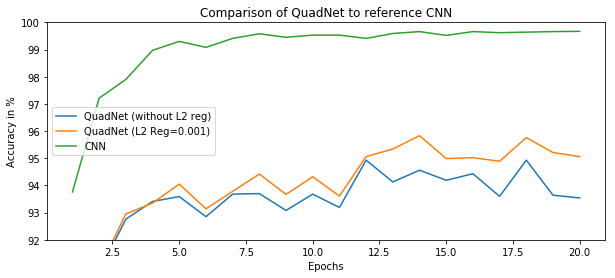

In [12]:
learn.show_results(results_cnn, 'Comparison of QuadNet to reference CNN', ymin=92, ymax=100)

As you can see our model is significantly outperformed by the baseline CNN, which is expected as it remains a very simple network. For the sake fo curiosity, we will also train it on the other tasks, which is the family recognition, and we will report results compared to the CNN.

### Accuracy results on the family recognition

In [13]:
family_results = {}
family_results['QuadNet Comp on Family rec.'] = main(model_type='quad', task='family', epochs=20)
family_results['CNN on Family rec'] = main(model_type='cnn', task='family', epochs=20)

Learning on family with quad 
Train Epoch: 1 [0/60000 (0%)]	Loss: 1.653749
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.232733
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.203530
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.182434

Test set: Average loss: 1.2120, Accuracy: 5038/10000 (50.38%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.107166
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.078658
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.189719
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.925714

Test set: Average loss: 1.0777, Accuracy: 5598/10000 (55.98%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 1.006163
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.871370
Train Epoch: 3 [38400/60000 (64%)]	Loss: 1.033807
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.925843

Test set: Average loss: 1.0681, Accuracy: 5653/10000 (56.53%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.894167
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.783592
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.870153
Train Epoch: 4 [57600/60000 (96%)]	Loss: 1.12220

Train Epoch: 12 [38400/60000 (64%)]	Loss: 0.051301
Train Epoch: 12 [57600/60000 (96%)]	Loss: 0.072218

Test set: Average loss: 0.1294, Accuracy: 9541/10000 (95.41%)

Train Epoch: 13 [0/60000 (0%)]	Loss: 0.067526
Train Epoch: 13 [19200/60000 (32%)]	Loss: 0.067250
Train Epoch: 13 [38400/60000 (64%)]	Loss: 0.072079
Train Epoch: 13 [57600/60000 (96%)]	Loss: 0.042483

Test set: Average loss: 0.1114, Accuracy: 9609/10000 (96.09%)

Train Epoch: 14 [0/60000 (0%)]	Loss: 0.038953
Train Epoch: 14 [19200/60000 (32%)]	Loss: 0.063330
Train Epoch: 14 [38400/60000 (64%)]	Loss: 0.048262
Train Epoch: 14 [57600/60000 (96%)]	Loss: 0.044826

Test set: Average loss: 0.1154, Accuracy: 9595/10000 (95.95%)

Train Epoch: 15 [0/60000 (0%)]	Loss: 0.052410
Train Epoch: 15 [19200/60000 (32%)]	Loss: 0.020627
Train Epoch: 15 [38400/60000 (64%)]	Loss: 0.048731
Train Epoch: 15 [57600/60000 (96%)]	Loss: 0.035455

Test set: Average loss: 0.1259, Accuracy: 9573/10000 (95.73%)

Train Epoch: 16 [0/60000 (0%)]	Loss: 0.084042

If you have some time, you can run variants with regularization, but Disclaimer! it doesn't improve the model accuracy.

In [14]:
#reg_params = [0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01]
#for reg_param in reg_params:
#    family_results[f'QuadNet Comp on Family rec. (with L2 Reg={reg_param})'] = main(
#        model_type='quad', task='family', reg_l2=reg_param, epochs=20
#    )
    

However, we will change the actual optimizer and its hyper parameters to try improving the model performance.
We will use the `main` function provided in our `learn` module, which performs similarly to the one described above, except you can provide your own optimizer.

In [15]:
from learn import main
from learn.models import QuadNet
import torch.optim as optim

In [16]:
hyperparam_results = {}
learning_rates = [0.001, 0.002, 0.005, 0.01]
momento = [0, 0.1, 0.5]
for lr in learning_rates:
    for momentum in momento:
        model = QuadNet(output_size=5)
        opt = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
        hyperparam_results[f'QuadNet Family rec. (lr={lr}, mom.={momentum})'] = main(
            model_type='quad', model=model, optimizer=opt, task='family', epochs=20
        )

Training set 60000 items
Testing set  10000 items
Learning on family with quad 
Train Epoch: 1 [0/60000 (0%)]	Loss: 1.803280
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.753252
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.671833
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.618188

Test set: Average loss: 1.4984, Accuracy: 3322/10000 (33.22%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.580101
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.593202
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.561841
Train Epoch: 2 [57600/60000 (96%)]	Loss: 1.527779

Test set: Average loss: 1.4208, Accuracy: 3919/10000 (39.19%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 1.573886
Train Epoch: 3 [19200/60000 (32%)]	Loss: 1.634884
Train Epoch: 3 [38400/60000 (64%)]	Loss: 1.477805
Train Epoch: 3 [57600/60000 (96%)]	Loss: 1.543290

Test set: Average loss: 1.3652, Accuracy: 4268/10000 (42.68%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 1.479200
Train Epoch: 4 [19200/60000 (32%)]	Loss: 1.652107
Train Epoch: 4 [38400/60000 (64%)]	Loss: 1.50701

Train Epoch: 12 [19200/60000 (32%)]	Loss: 1.433580
Train Epoch: 12 [38400/60000 (64%)]	Loss: 1.450287
Train Epoch: 12 [57600/60000 (96%)]	Loss: 1.227192

Test set: Average loss: 1.1043, Accuracy: 5636/10000 (56.36%)

Train Epoch: 13 [0/60000 (0%)]	Loss: 1.253479
Train Epoch: 13 [19200/60000 (32%)]	Loss: 1.241282
Train Epoch: 13 [38400/60000 (64%)]	Loss: 1.300470
Train Epoch: 13 [57600/60000 (96%)]	Loss: 1.321074

Test set: Average loss: 1.0877, Accuracy: 5690/10000 (56.90%)

Train Epoch: 14 [0/60000 (0%)]	Loss: 1.211259
Train Epoch: 14 [19200/60000 (32%)]	Loss: 1.173153
Train Epoch: 14 [38400/60000 (64%)]	Loss: 1.258204
Train Epoch: 14 [57600/60000 (96%)]	Loss: 1.166985

Test set: Average loss: 1.0764, Accuracy: 5761/10000 (57.61%)

Train Epoch: 15 [0/60000 (0%)]	Loss: 1.416949
Train Epoch: 15 [19200/60000 (32%)]	Loss: 1.026621
Train Epoch: 15 [38400/60000 (64%)]	Loss: 1.251469
Train Epoch: 15 [57600/60000 (96%)]	Loss: 1.073148

Test set: Average loss: 1.0623, Accuracy: 5833/10000 (58.

Train Epoch: 3 [19200/60000 (32%)]	Loss: 1.523375
Train Epoch: 3 [38400/60000 (64%)]	Loss: 1.415144
Train Epoch: 3 [57600/60000 (96%)]	Loss: 1.469291

Test set: Average loss: 1.2572, Accuracy: 4890/10000 (48.90%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 1.352190
Train Epoch: 4 [19200/60000 (32%)]	Loss: 1.618556
Train Epoch: 4 [38400/60000 (64%)]	Loss: 1.425812
Train Epoch: 4 [57600/60000 (96%)]	Loss: 1.311395

Test set: Average loss: 1.2048, Accuracy: 5156/10000 (51.56%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 1.352286
Train Epoch: 5 [19200/60000 (32%)]	Loss: 1.474179
Train Epoch: 5 [38400/60000 (64%)]	Loss: 1.308807
Train Epoch: 5 [57600/60000 (96%)]	Loss: 1.087162

Test set: Average loss: 1.1615, Accuracy: 5362/10000 (53.62%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 1.259391
Train Epoch: 6 [19200/60000 (32%)]	Loss: 1.180900
Train Epoch: 6 [38400/60000 (64%)]	Loss: 1.294796
Train Epoch: 6 [57600/60000 (96%)]	Loss: 1.240804

Test set: Average loss: 1.1296, Accuracy: 5520/10000 (55.20%)

Train Epo

Train Epoch: 14 [38400/60000 (64%)]	Loss: 1.122271
Train Epoch: 14 [57600/60000 (96%)]	Loss: 1.064627

Test set: Average loss: 0.9774, Accuracy: 6136/10000 (61.36%)

Train Epoch: 15 [0/60000 (0%)]	Loss: 1.345334
Train Epoch: 15 [19200/60000 (32%)]	Loss: 0.916187
Train Epoch: 15 [38400/60000 (64%)]	Loss: 1.188805
Train Epoch: 15 [57600/60000 (96%)]	Loss: 0.987435

Test set: Average loss: 0.9695, Accuracy: 6183/10000 (61.83%)

Train Epoch: 16 [0/60000 (0%)]	Loss: 0.985380
Train Epoch: 16 [19200/60000 (32%)]	Loss: 1.008929
Train Epoch: 16 [38400/60000 (64%)]	Loss: 0.941421
Train Epoch: 16 [57600/60000 (96%)]	Loss: 1.157167

Test set: Average loss: 0.9711, Accuracy: 6132/10000 (61.32%)

Train Epoch: 17 [0/60000 (0%)]	Loss: 1.059437
Train Epoch: 17 [19200/60000 (32%)]	Loss: 1.134013
Train Epoch: 17 [38400/60000 (64%)]	Loss: 1.046699
Train Epoch: 17 [57600/60000 (96%)]	Loss: 1.252714

Test set: Average loss: 0.9632, Accuracy: 6162/10000 (61.62%)

Train Epoch: 18 [0/60000 (0%)]	Loss: 1.055237

Train Epoch: 5 [19200/60000 (32%)]	Loss: 1.227840
Train Epoch: 5 [38400/60000 (64%)]	Loss: 1.096165
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.956156

Test set: Average loss: 1.0351, Accuracy: 5859/10000 (58.59%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 1.150784
Train Epoch: 6 [19200/60000 (32%)]	Loss: 1.054727
Train Epoch: 6 [38400/60000 (64%)]	Loss: 1.094813
Train Epoch: 6 [57600/60000 (96%)]	Loss: 1.102331

Test set: Average loss: 1.0152, Accuracy: 5930/10000 (59.30%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 1.122968
Train Epoch: 7 [19200/60000 (32%)]	Loss: 1.014949
Train Epoch: 7 [38400/60000 (64%)]	Loss: 1.051547
Train Epoch: 7 [57600/60000 (96%)]	Loss: 1.175336

Test set: Average loss: 1.0136, Accuracy: 5896/10000 (58.96%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 1.407277
Train Epoch: 8 [19200/60000 (32%)]	Loss: 1.148914
Train Epoch: 8 [38400/60000 (64%)]	Loss: 1.175107
Train Epoch: 8 [57600/60000 (96%)]	Loss: 1.079705

Test set: Average loss: 0.9883, Accuracy: 6048/10000 (60.48%)

Train Epo

Train Epoch: 16 [38400/60000 (64%)]	Loss: 0.904730
Train Epoch: 16 [57600/60000 (96%)]	Loss: 1.081320

Test set: Average loss: 0.9276, Accuracy: 6318/10000 (63.18%)

Train Epoch: 17 [0/60000 (0%)]	Loss: 1.110856
Train Epoch: 17 [19200/60000 (32%)]	Loss: 0.993715
Train Epoch: 17 [38400/60000 (64%)]	Loss: 0.976719
Train Epoch: 17 [57600/60000 (96%)]	Loss: 1.199284

Test set: Average loss: 0.9309, Accuracy: 6373/10000 (63.73%)

Train Epoch: 18 [0/60000 (0%)]	Loss: 0.957126
Train Epoch: 18 [19200/60000 (32%)]	Loss: 0.923751
Train Epoch: 18 [38400/60000 (64%)]	Loss: 0.916183
Train Epoch: 18 [57600/60000 (96%)]	Loss: 1.134319

Test set: Average loss: 0.9122, Accuracy: 6397/10000 (63.97%)

Train Epoch: 19 [0/60000 (0%)]	Loss: 1.185894
Train Epoch: 19 [19200/60000 (32%)]	Loss: 1.118415
Train Epoch: 19 [38400/60000 (64%)]	Loss: 0.987153
Train Epoch: 19 [57600/60000 (96%)]	Loss: 0.927724

Test set: Average loss: 0.9200, Accuracy: 6462/10000 (64.62%)

Train Epoch: 20 [0/60000 (0%)]	Loss: 1.065482

Train Epoch: 7 [19200/60000 (32%)]	Loss: 1.025973
Train Epoch: 7 [38400/60000 (64%)]	Loss: 1.031374
Train Epoch: 7 [57600/60000 (96%)]	Loss: 1.098563

Test set: Average loss: 1.0085, Accuracy: 5841/10000 (58.41%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 1.334828
Train Epoch: 8 [19200/60000 (32%)]	Loss: 1.118005
Train Epoch: 8 [38400/60000 (64%)]	Loss: 1.198096
Train Epoch: 8 [57600/60000 (96%)]	Loss: 1.024731

Test set: Average loss: 1.0199, Accuracy: 5866/10000 (58.66%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 1.047977
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.983127
Train Epoch: 9 [38400/60000 (64%)]	Loss: 1.048301
Train Epoch: 9 [57600/60000 (96%)]	Loss: 1.159009

Test set: Average loss: 0.9885, Accuracy: 6087/10000 (60.87%)

Train Epoch: 10 [0/60000 (0%)]	Loss: 1.172702
Train Epoch: 10 [19200/60000 (32%)]	Loss: 0.995935
Train Epoch: 10 [38400/60000 (64%)]	Loss: 0.982511
Train Epoch: 10 [57600/60000 (96%)]	Loss: 1.019741

Test set: Average loss: 0.9719, Accuracy: 6120/10000 (61.20%)

Train

Train Epoch: 18 [38400/60000 (64%)]	Loss: 0.992108
Train Epoch: 18 [57600/60000 (96%)]	Loss: 1.195346

Test set: Average loss: 0.9294, Accuracy: 6304/10000 (63.04%)

Train Epoch: 19 [0/60000 (0%)]	Loss: 1.127873
Train Epoch: 19 [19200/60000 (32%)]	Loss: 1.192387
Train Epoch: 19 [38400/60000 (64%)]	Loss: 0.966425
Train Epoch: 19 [57600/60000 (96%)]	Loss: 0.927055

Test set: Average loss: 0.9488, Accuracy: 6259/10000 (62.59%)

Train Epoch: 20 [0/60000 (0%)]	Loss: 1.148540
Train Epoch: 20 [19200/60000 (32%)]	Loss: 1.037508
Train Epoch: 20 [38400/60000 (64%)]	Loss: 1.093942
Train Epoch: 20 [57600/60000 (96%)]	Loss: 1.009770

Test set: Average loss: 0.9432, Accuracy: 6198/10000 (61.98%)

Training set 60000 items
Testing set  10000 items
Learning on family with quad 
Train Epoch: 1 [0/60000 (0%)]	Loss: 1.822279
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.412149
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.266185
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.282678

Test set: Average loss: 1.1615, 

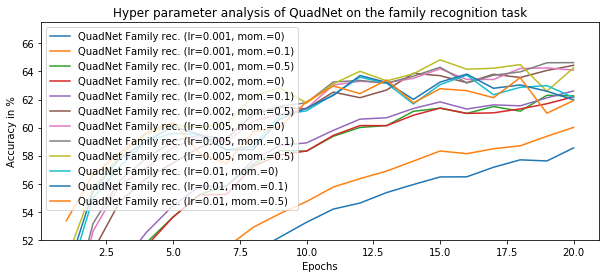

In [17]:
title = 'Hyper parameter analysis of QuadNet on the family recognition task'
learn.show_results(hyperparam_results, title, ymin=52, ymax=67.5)

**Observation** The higher the learning rate is, the less smooth the learning curve is.

This hyperparameter tuning suggests that the setting `(lr=0.005, mom.=0.5)` can help doing a `+4%` accuracy at `64.4%` (averaged on the 5 last epochs), compared to `60.0%` on the baseline `(lr=0.01, mom.=0.5)`. This helps but remains really unsufficient compared to CNN.

In [22]:
lr = 0.005
momentum = 0.5
family_results[f'QuadNet Family rec. (lr={lr}, mom.={momentum})'] = hyperparam_results[f'QuadNet Family rec. (lr={lr}, mom.={momentum})']

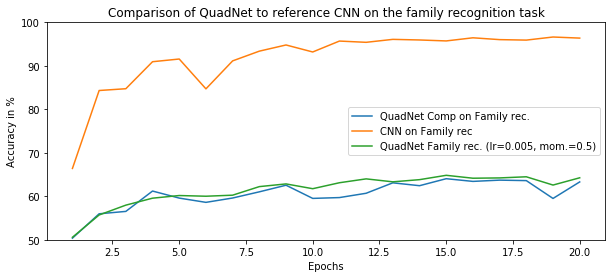

In [23]:
title = 'Comparison of QuadNet to reference CNN on the family recognition task'
learn.show_results(family_results, title, ymin=50, ymax=100)

**Conclusion on family recognition**

In this task, we can observe that the Quadratic network is not suited to this kind of training, because of its simplicity, while the CNN performs really well.

The next question for us is: can we use the output of the quadratic net to feed another network to make a better prediction than the simple argmax we're currently performing?
We will provide an extended analysis of models that we can put on top to improve the global accuracy in Part 3.